In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

### Download the dataset 

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170418176/170498071 [01:56<00:00, 1705978.52it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


170500096it [02:10, 1705978.52it/s]                               

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

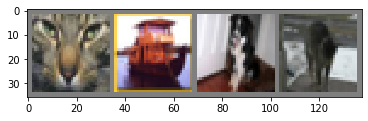

In [4]:
imshow(torchvision.utils.make_grid(images))

In [5]:
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

  cat  ship   dog   cat


### Define a Convolutional Neural Network

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5) # in_channels = 3, out_channels = 6, kernel_size = 5x5, stride = 1
        self.pool = nn.MaxPool2d(2, 2) # kernel_size = 2, stride = 2
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120) # y = Ax+b: in_features = 16x5x5, out_features = 120 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # loss function 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [11]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.149
[1,  4000] loss: 1.784
[1,  6000] loss: 1.619
[1,  8000] loss: 1.512
[1, 10000] loss: 1.431
[1, 12000] loss: 1.359
[2,  2000] loss: 1.302
[2,  4000] loss: 1.260
[2,  6000] loss: 1.236
[2,  8000] loss: 1.170
[2, 10000] loss: 1.152
[2, 12000] loss: 1.133
[3,  2000] loss: 1.024
[3,  4000] loss: 1.041
[3,  6000] loss: 1.016
[3,  8000] loss: 1.026
[3, 10000] loss: 0.999
[3, 12000] loss: 1.002
[4,  2000] loss: 0.903
[4,  4000] loss: 0.894
[4,  6000] loss: 0.912
[4,  8000] loss: 0.903
[4, 10000] loss: 0.894
[4, 12000] loss: 0.889
[5,  2000] loss: 0.801
[5,  4000] loss: 0.816
[5,  6000] loss: 0.815
[5,  8000] loss: 0.826
[5, 10000] loss: 0.829
[5, 12000] loss: 0.808
Finished Training


### Save the model

In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Test the network

In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()

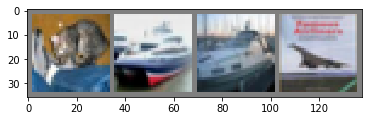

GroundTruth:    cat  ship  ship plane


In [18]:
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
images = images.to(device)
outputs = net(images)

In [20]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car plane


In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 68 %


In [27]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 86 %
Accuracy of  bird : 53 %
Accuracy of   cat : 70 %
Accuracy of  deer : 58 %
Accuracy of   dog : 41 %
Accuracy of  frog : 79 %
Accuracy of horse : 66 %
Accuracy of  ship : 77 %
Accuracy of truck : 74 %
